In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn import model_selection
from sklearn.metrics import accuracy_score

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
labels_path = "data/words.txt"
lines = []

# extract from labels file the path to the image and the label string
with open(labels_path, "r") as file:
    file = file.readlines()
    for line in file:
        line = line.split(" ")
        # skip comment lines and lines with incorrect labels
        if line[0][0] == "#":
            continue
        elif line[1] == "err":
            continue
        lines.append(line[0] + " " + line[-1].replace("\n", ""))

np.random.shuffle(lines)

In [ ]:
characters = {' '}

def clean_lines(line_list):
    paths = []
    labels = []
    for line in line_list:
        path, label = line.split(" ")
        path = path.split("-")
        # path to the image in the file is in the incorrect form, so we change it here
        path = f"data/words/{path[0]}/{path[0]}-{path[1]}/{'-'.join(path)}.png"
        
        # some of the .png files in the dataset are empty, so the check is necessary
        try:
            image = tf.io.read_file(path)
            tf.image.decode_png(image, 1)
        except Exception:
            continue
        paths.append(path)
        
        # put every unique character into dictionary
        label = label.split(" ")[-1].strip()
        for char in label:
            characters.add(char)
        labels.append(label)
    
    return paths, labels

X, y = clean_lines(lines[:60000])
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)


# find sentance with max len to use it in padding
max_len = 0
for i in y_train + y_test:
    if len(i) > max_len:
        max_len = len(i)
    
# we create a dictionary of symbols, in order to represent words in neural network
vocabulary = dict()
idx = 0

for character in list(characters):
    vocabulary[character] = idx
    idx += 1

In [ ]:
padding_token = vocabulary[' '] # get the id of space
image_height = 32
image_width = 64

# try different batch sizes to pick the one, that evenly splits train set
batch_size = 1
for try_batch_size in range(50, 500):
    if len(y_train) % try_batch_size  == 0:
        batch_size = try_batch_size
        break


# convert sequnce of characters to sequence of numbers and pad it to make all sequances equal size
def vectorize_pad_labels(labels):
    vec_labels = []
    for label in labels:
        new_label = np.array(([vocabulary[char] for char in label]))
        new_label = tf.convert_to_tensor(new_label)
        new_label = tf.pad(new_label, paddings=[[0, max_len-tf.shape(new_label)[0]]], constant_values=padding_token)
        vec_labels.append(new_label)
    return np.array(vec_labels)


def pad_images(images):
    processed_images = []
    for image in images:
        image = tf.io.read_file(image)
        image = tf.image.decode_png(image, 1)
        
        # image won't be resized exactly to needed size because of preserve_aspect_ratio=True, so that we can calculate padding
        image = tf.image.resize(image, size=(image_height, image_width), preserve_aspect_ratio=True)
        
        pad_height = image_height - tf.shape(image)[0]
        pad_width = image_width - tf.shape(image)[1]
        
        
        # check if the padding is equal on all sides
        if pad_height % 2 != 0:
            height = pad_height // 2
            pad_height_top = height + 1
            pad_height_bottom = height
        else:
            pad_height_top = pad_height_bottom = pad_height // 2

        if pad_width % 2 != 0:
            width = pad_width // 2
            pad_width_left = width + 1
            pad_width_right = width
        else:
            pad_width_left = pad_width_right = pad_width // 2
        
        image = tf.pad(image, paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right], 
            [0,0]])

        
        # normalize image to make all values in between 0 and 1
        image = tf.cast(image, tf.float32) / 255.0
        processed_images.append(image)

    return np.array(processed_images)
        

def load_data(images, labels):
    images = pad_images(images)
    labels = vectorize_pad_labels(labels)
    return {"images": images, "labels": labels}

train = load_data(X_train, y_train)
test = load_data(X_test, y_test)

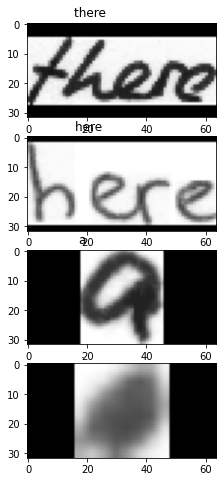

In [ ]:
# plot a couple of images, just to see how it looks

_, ax = plt.subplots(4, figsize=(10, 8))
idx = 0
for image, label in zip(train["images"], train["labels"]):

    # decode label sequence
    new_label = ""
    for num in label:
        new_label += list(vocabulary.keys())[list(vocabulary.values()).index(int(num))]

    # transfer image to its original form
    image = (image * 255.0).clip(0, 255).astype(np.uint8)

    ax[idx].imshow(image, cmap="gray")
    ax[idx].set_title(new_label)
    idx += 1
    if idx > 3:
        break

plt.show()

In [ ]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # change sequences to apropiate form
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length) # calculate ctc loss
        self.add_loss(loss)

        return y_pred

def Handwriting_Recognition():
    images = keras.Input(shape=[image_height, image_width, 1], name="images")
    labels = keras.layers.Input(shape=(None,), name="labels")

    cnn = keras.layers.Conv2D(32, (5,5), kernel_initializer=keras.initializers.he_normal(), padding='same',
                              activation='relu')(images)
    max_pool = keras.layers.MaxPool2D()(cnn)
    
    cnn = keras.layers.Conv2D(32, (5,5), kernel_initializer=keras.initializers.he_normal(), padding='same',
                              activation='relu')(max_pool)
    
    cnn = keras.layers.Conv2D(32, (3,3), kernel_initializer=keras.initializers.he_normal(), padding='same',
                              activation='relu')(cnn)
    cnn = keras.layers.Conv2D(32, (3,3), kernel_initializer=keras.initializers.he_normal(), padding='same',
                              activation='relu')(cnn)
    cnn = keras.layers.Conv2D(32, (3,3), kernel_initializer=keras.initializers.he_normal(), padding='same',
                              activation='relu')(cnn)
    


    reshape = keras.layers.Reshape((image_width, (image_height//2)*16))(cnn)

    dense = keras.layers.Dense(256, kernel_initializer=keras.initializers.he_normal(), activation='tanh')(reshape)
    dropout = keras.layers.Dropout(0.2)(dense)

    lstm1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(dropout)
    lstm2 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(lstm1)


    softmax = keras.layers.Dense(len(characters)+2, activation='softmax', name="softmax")(lstm2)

    output = CTCLayer(name="ctc_loss")(labels, softmax)

    model = keras.Model(inputs=[images, labels], outputs=output)
    model.compile(optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    return model


model = Handwriting_Recognition()
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 32, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 32, 64, 32)   832         images[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 16, 32, 32)   0           conv2d_62[0][0]                  
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 16, 32, 32)   25632       max_pooling2d_8[0][0]            
___________________________________________________________________________________________

In [ ]:
prediction_model = keras.models.Model(model.get_layer(name="images").input,
                                      model.get_layer(name="softmax").output) # get the softmax output

model.fit(train, batch_size=batch_size, epochs=10)